
# Resolución SD0

# Modelo Difusión 🧪  [⚫⚫⚫ | 〰️ | ⚪⚪ ]
Un modelo de difusión describe la transferencia de una sustancia entre dos regiones debido a un gradiente de concentración. En este caso, consideramos dos volúmenes distintos donde la sustancia se mueve de una región a otra según una constante de difusión $ k $.

Consideramos el sistema diferencial ordinario (SDO):

\begin{equation}
\begin{cases}
\frac{dy_1}{dt} = k \left(\frac{y_2}{V_2} - \frac{y_1}{V_1} \right), \\
\frac{dy_2}{dt} = k \left(\frac{y_1}{V_1} - \frac{y_2}{V_2} \right).
\end{cases}
\end{equation}

A continuación, definimos el código utilizando *PyTorch*:

In [7]:
# Importar librerias
import numpy as np                                # Librería de cálculo numérico
import matplotlib.pyplot as plt                   # Librería de gráficos
from matplotlib.animation import FuncAnimation    # Librería para crear animaciones en gráficos generados con Matplotlib
from matplotlib.animation import FFMpegWriter     # Librería para guardar animaciones en formato vídeo
import torch
import torch.nn as nn                             # Librería de redes neuronales
import torch.optim as optim                       # Optimizador para entrenar la red neuronal y modificar sus pesos
import torch.nn.init as init                      # Inicializar los parámetros de los modelos de redes neuronales
import torch.autograd as grad                     # Cálculo automático de gradientes
import time                                       # Funciones para medir tiempos de ejecución
from scipy.integrate import solve_ivp             # Librería para resolver sistemas de ecuaciones diferenciales ordinarias (ODEs)
import math                                       # Librería da acceso a funciones elementales (trigonometría, exponenciales, etc.) y constantes matemáticas
!apt-get install ffmpeg
from IPython.display import Video                 # Mostrar videos directamente dentro de notebooks Jupyter/Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### Datos iniciales

In [117]:
N=5000
Nf = 2000 # puntos para evaluar el residuo
print_freq = 2500 # imprimir cada epoca

# Intervalo de integración

t0,tf = 0.0,40

# Volúmenes de los conjuntos

V1 = 1.0
V2 = 2.0
y10,y20 = 1.0, 0.0
y0 = np.array([y10,y20], float)

# Parámetros de difusión
k= 0.1 # Constante de difusión

### Definición

In [118]:
def DifusionSD0(t, y, k, V1, V2):
    """
    t  : Tiempo (variable independiente)
    y  : Vector con las cantidades de sustancia en dos regiones [y1, y2] (variables dependientes)
    k  : Constante de difusión (controla la velocidad de transferencia)
    V1 : Volumen de la región 1
    V2 : Volumen de la región 2
    """

    # Extraemos las cantidades de sustancia de cada región
    y1 = y[0]    # Cantidad de sustancia en región 1 (omega1)
    y2 = y[1]    # Cantidad de sustancia en región 2 (omega2)

    # Ecuaciones diferenciales
    dy1dt = k * (y2 / V2) - k * (y1 / V1)
    dy2dt = k * (y1 / V1) - k * (y2 / V2)

    return np.array([dy1dt, dy2dt], float)


### -> Runge-Kutta Simpson (de 3er. Orden)

In [119]:
def RungeKuttaSimpson(f, I, y0, N, k, V1, V2):
    """
% Entrada:
%       f   : funcion f(t,y)
%       y0  : dato inicial
%       I   : intervalo de integracion [t0,tf] (un vector)
%       N   : numero de subintervalos en [t0,tf]
%              (N+1 nodos en [t0,tf])
% Salida:
%      y : vector con N+1 valores aproximados de la solucion
%      t : vector con N+1 nodos de [t0,tf]
  """
  # Discretización
    t0 = I[0]
    tf = I[1]
    N1 = N + 1
    M = len(y0)
    t = np.linspace(t0, tf, N1) # Vector de tiempos
    h = (tf - t0) / N           # Paso de tiempo

  # Inicialización
    y = np.zeros((M, N1))       # Adimensionalización: Vector 'y' tenga la dimensión necesaria
    y[:, 0] = y0
  # Iteraciones
    h2 = h * 0.5
    h6 = h / 6
    t2 = t + h2

    for n in range(N):
        p1 = f(t[n], y[:,n], k, V1, V2)
        p2 = f(t2[n], y[:,n] + h2 * p1, k, V1, V2)
        p3 = f(t[n] + h, y[:,n] + h * (2 * p2 + p1), k, V1, V2)
        y[:, n+1] = y[:, n] + h6 * (p1 + 4 * p2 + p3)

    return t, y

### Resolución y representación gráfica

Epoch 0: t = 0.0, y1 = 1.0, y2 = 0.0
Epoch 2500: t = 20.0, y1 = 0.3665646136722465, y2 = 0.6334353863277548


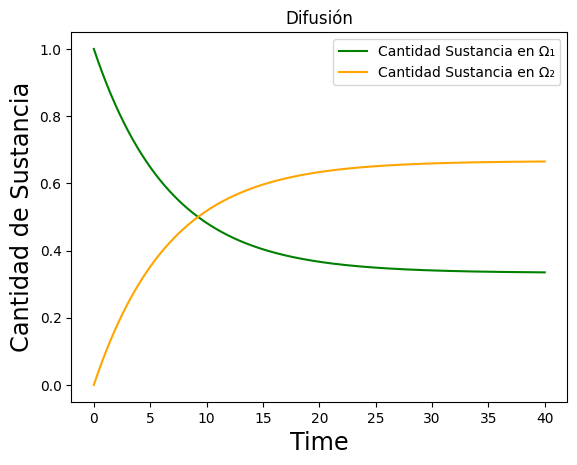

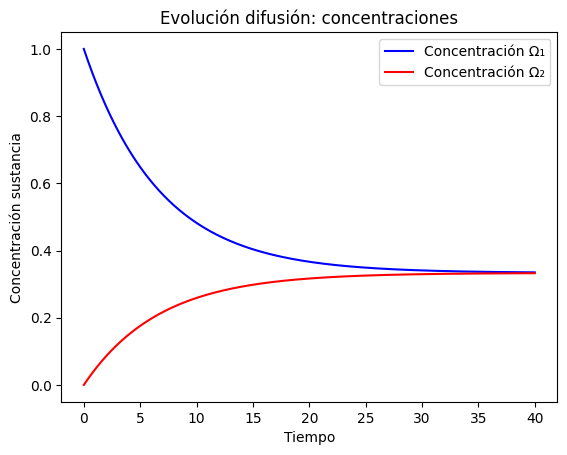

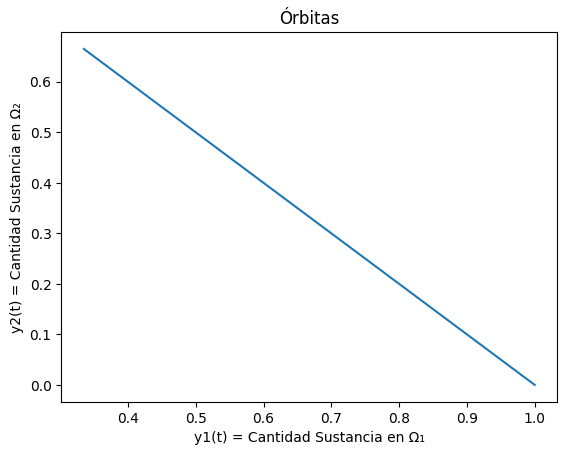

In [120]:
t, y = RungeKuttaSimpson(DifusionSD0, [t0, tf], y0, N, k, V1, V2)

# Extraer las soluciones para omega1 y omega2

y1 = y[0,:]
y2 = y[1,:]

# Imprimir cada `print_freq` épocas
# Variación de las soluciones en intervalos específicos
for epoch in range(0, N, print_freq):
    print(f"Epoch {epoch}: t = {t[epoch]}, y1 = {y1[epoch]}, y2 = {y2[epoch]}")

# Representación de la solucion
fig1 = plt.figure(1)
plt.plot(t, y1, 'g', label = "Cantidad Sustancia en Ω₁")
plt.plot(t, y2, color ='orange', label = "Cantidad Sustancia en Ω₂")
plt.title("Difusión")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("Cantidad de Sustancia",fontsize="xx-large")
plt.legend(loc='best')  # 'best' encuentra la mejor ubicación automáticamente
plt.show()

# Concentraciones
fig2 = plt.figure(2)
plt.plot(t,y1/V1,'b',label="Concentración Ω₁")
plt.plot(t,y2/V2,'r',label="Concentración Ω₂")
plt.title('Evolución difusión: concentraciones')
plt.xlabel('Tiempo')
plt.ylabel('Concentración sustancia')
plt.legend(loc='best')

# Espacio de fases
fg3 = plt.figure(3)
plt.plot(y1, y2)
plt.title("Órbitas")
plt.xlabel("y1(t) = Cantidad Sustancia en Ω₁")
plt.ylabel("y2(t) = Cantidad Sustancia en Ω₂")
plt.show()


### -> solve_ivp

In [121]:
# Como odeint espera que la función tenga esta forma:
# def f(t, y, *params):

def DifusionSD0_ivp(t, y, k, V1, V2):
    y1 = y[0]
    y2 = y[1]
    dy1dt = k * (y2 / V2) - k * (y1 / V1)
    dy2dt = k * (y1 / V1) - k * (y2 / V2)
    return [dy1dt, dy2dt]

### Resolución y representación gráfica

Solución de la integración (sol):   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.000e-03 ...  3.999e+01  4.000e+01]
        y: [[ 1.000e+00  9.992e-01 ...  3.350e-01  3.350e-01]
            [ 0.000e+00  7.995e-04 ...  6.650e-01  6.650e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0


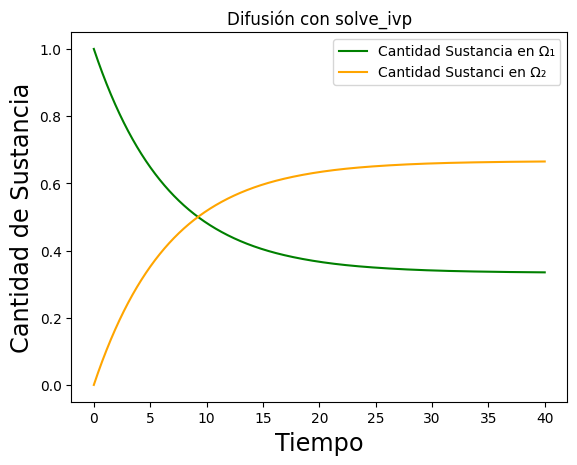

<ipython-input-122-257151288>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


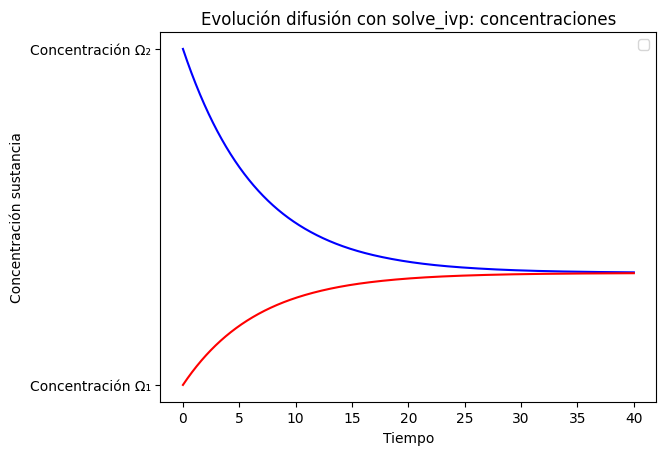

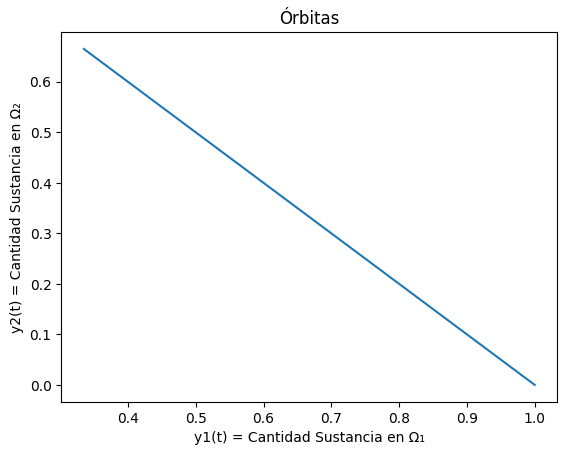

In [122]:
sol = solve_ivp(DifusionSD0, (t0,tf), y0, args=(k, V1, V2), t_eval = t)

# Mostrar la solución
print("Solución de la integración (sol):", sol)

# Representación de la solucion
fig4 = plt.figure(4)
plt.plot(sol.t, sol.y[0], 'g', label = "Cantidad Sustancia en Ω₁")
plt.plot(sol.t, sol.y[1], color='orange', label="Cantidad Sustanci en Ω₂")
plt.title("Difusión con solve_ivp")
plt.xlabel("Tiempo",fontsize="xx-large")
plt.ylabel("Cantidad de Sustancia",fontsize="xx-large")
plt.legend(loc='best')
plt.show()

# Concentraciones
fig2 = plt.figure(2)
plt.plot(sol.t,sol.y[0]/V1,'b','Concentración Ω₁')
plt.plot(sol.t,sol.y[1]/V2,'r','Concentración Ω₂')
plt.title('Evolución difusión con solve_ivp: concentraciones')
plt.xlabel("Tiempo")
plt.ylabel("Concentración sustancia")
plt.legend(loc='best')
plt.show()

# Espacio de fases
fig3 = plt.figure(3)
plt.plot(sol.y[0],sol.y[1])
plt.title("Órbitas")
plt.xlabel("y1(t) = Cantidad Sustancia en Ω₁")
plt.ylabel("y2(t) = Cantidad Sustancia en Ω₂")
plt.show()


### Definición red neuronal

In [123]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)

In [124]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


Principales características:
- Arquitectura: Red neuronal feedforward con 3 capas
- Activación: Se aplica la función de activación tangente hiperbólica (tanh) en las primeras dos capas, mientras que la última capa no tiene activación (salida directa)
- Inicialización de pesos: Se utiliza la inicialización Xavier (o Glorot), que es adecuada para redes con funciones de activación como tanh

In [125]:
# Definición de Red Neuronal de Propagación Adelante (Feedforward)

class PINN(nn.Module):                                           # Clase PINN es una subclase de nn.Module

    def __init__(self, input_size, hidden_size, output_size):    # Constructor que se ejecuta cuando se crea una instancia de la clase PINN
                                                                 # Este método inicializa las capas de la red neuronal
        super(PINN, self).__init__()                             # Llama al constructor de la clase base nn.Module


        # Capas de la red neuronal (3 capas lineales: nn.Linear)

        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => Salida = Entradas × Pesos + Sesgo

        # Capa 1: Recibe input_size características como entrada y produce hidden_size características como salida
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Recibe hidden_size características de la capa anterior y devuelve hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Recibe hidden_size características y devuelve output_size características (salida final de la red)
        self.fc6 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos:

        # 1) Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)       # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)                # Distribución uniforme

        # 2) Xavier/Glorot Initialization
        # Técnica usada para redes neuronales con funciones de activación como la tangente hiperbólica (torch.tanh)
        # Esta inicialización: - ayuda a que la varianza de los valores de las activaciones permanezca constante entre capas
        #                      - mejora la estabilidad del entrenamiento

        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        nn.init.xavier_normal_(self.fc6.weight)

        # Inicializacion de las bias
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)
        nn.init.zeros_(self.fc4.bias.data)
        nn.init.zeros_(self.fc5.bias.data)
        nn.init.zeros_(self.fc6.bias.data)
    # Propagación hacia adelante (forward):

    def forward(self, x):

       # Método forward: define cómo los datos pasan a través de la red
       # 1) Los datos de entrada x pasan por la capa 1 (fc1), y luego se les aplica la función de activación tangente hiperbólica (torch.tanh)
       # 2) Lo mismo ocurre con la capa 2 (fc2), aplicando nuevamente torch.tanh
       # 3) Finalmente, en la capa 3 (fc3), no se aplica ninguna función de activación, y los resultados se devuelven tal como están
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = torch.tanh(self.fc5(x))
       x = self.fc6(x)                                             # No aplicamos función de activación en la última capa fc3

       return x


In [78]:
# Calculamos la derivada
def compute_derivative(model, x):
    g = x.clone()
    g.requires_grad_(True)         # Activar el flag requires_grad para que se realice el seguimiento de gradientes
    y_real = model(g)              # Obtener las predicciones de la red para las entradas
    r1=y_real[:,0].view(2000,1)
    r2=y_real[:,1].view(2000,1)
    r1_t = torch.autograd.grad(r1, g, grad_outputs=torch.ones_like(r1), retain_graph = True, create_graph=True)[0]
    r2_t = torch.autograd.grad(r2, g, grad_outputs=torch.ones_like(r2), retain_graph = True, create_graph=True)[0]
    return r1,r2,r1_t, r2_t

# Función para calcular la condición inicial
def initial_condition(model, x_initial):
    return model(x_initial*torch.ones(1,1))

In [79]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self,model, r1_t, r2_t, r1, r2, t0, y0):
        loss_pde = self.mse_loss(r1_t, torch.Tensor(k * (r2 / V2) - k * (r1 / V1)))
        loss_pde += self.mse_loss(r2_t, torch.Tensor(k * (r1 / V1) - k * (r2 / V2)))
        y_0 = initial_condition(model, t0)
        loss_initial_condition = self.mse_loss(y_0, y0)
        total_loss = loss_pde + loss_initial_condition
        return total_loss

In [80]:
y0 = torch.tensor(y0)
y0

<ipython-input-80-2845427214>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0)


tensor([1., 0.])

### Datos de entrenamiento


In [81]:
# Impresión de las formas (shape) de los tensores t y sol

# t := vector de tiempo.
#      Tendrá la forma (N, ) donde N es el número de puntos temporales
print(sol.t.shape)

# sol := matriz de soluciones con múltiples variables dependientes.
#        Tendrá la forma de (N, M) donde N es el número de puntos de tiempo y M es el número de variables dependientes
print(sol.y.shape)

# Submuestreo de los datos
# Al utilizar un paso de 1 en el índice (::1),no se están eliminando elementos

t = sol.t[::1]
y = sol.y[:, ::1]

# Conversión a tensores de PyTorch

t = torch.Tensor(t).view(-1,1)    # Convierte t en un tensor de PyTorch y luego cambia su forma.
                                  # Al usar .view(-1, 1), aseguras que t tendrá una forma de (N, 1), donde cada valor de t es una fila
                                  # Apropiado para muchas redes neuronales que esperan una entrada con forma (N, 1) en el caso de datos univariantes
y = torch.Tensor(y.T)             # Convierte la variable y (solución) en un tensor de PyTorch

# Formas de t y y después de las modificaciones
t.shape
y.shape

# Visualización de y
y

(5001,)
(2, 5001)


tensor([[1.0000e+00, 0.0000e+00],
        [9.9920e-01, 7.9952e-04],
        [9.9840e-01, 1.5981e-03],
        ...,
        [3.3502e-01, 6.6498e-01],
        [3.3502e-01, 6.6498e-01],
        [3.3502e-01, 6.6498e-01]])

### Número de datos de entrenamiento

In [82]:
# n := número de intervalos que se tomarán en la selección de los datos
# N := número total de datos
# En este caso N = 5000

# j := número de datos que deseas usar para el entrenamiento
j = 40
#j = 16
#j = 60

n = math.ceil(N/j)     # redondeo hacia arriba
                       # asegura que tomes una cantidad de datos lo suficientemente grande para cubrir todo el rango
                       # Si n es grande, estarás seleccionando menos datos para el entrenamiento, y si es pequeño, más datos serán seleccionados
n

# Tomamos 40 datos para el entrenamiento ( j=40)
# n = 125, lo que significa que seleccionarás un punto cada 125 elementos en los vectores t y y.

#t_real = t[::125]
#y_real = y[::125]

# Tomamos 16, peor que 40
#t_real = t[::313]    Valor alto de n => menos puntos para el entrenamiento,
#                                        que puede hacer que el modelo no aprenda suficientemente bien de los datos // Ajuste insuficiente
#y_real = y[::313]

# Tomamos 60, mejor que 40
#t_real = t[::84]     Valor bajo de n => demasidos puntos
#                                        podría no generalizar bien a nuevos datos no vistos // Sobreajuste
#y_real = y[::84]

# Selección de datos de entrenamiento (tomando un paso de n)
# Al usar el índice de paso n, estás seleccionando un subconjunto de datos de t y y (con la misma cantidad de puntos) a intervalos regulares
#    - EJEMPLO: si n = 4, estarías seleccionando cada cuarto valor de t y su correspondiente valor en y
#               (resulta un subconjunto más pequeño de datos)
# Tomamos j
t_real = t[::n]
y_real = y[::n]

# Formas de los datos de entrenamiento
# Verificar que las variables tengan el mismo número de elementos, ya que
# t_data y y_data representan los puntos de tiempo y sus correspondientes soluciones

t_real.shape, y_real.shape

(torch.Size([41, 1]), torch.Size([41, 2]))

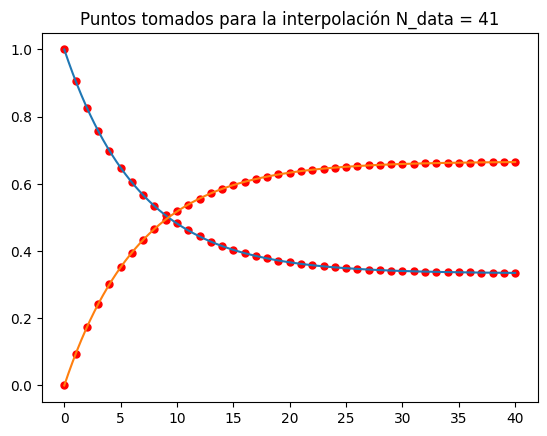

In [87]:
plt.figure()
plt.plot(t,y)
# Puntos seleccionados para la interpolación
plt.scatter(t_real,y_real[:,0], c="red",s=25)
plt.scatter(t_real,y_real[:,1], c="red",s=25)
plt.title(f'Puntos tomados para la interpolación N_data = {len(y_real)}')
plt.show()

### Entrenamiento de la red neuronal

In [84]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t0, y0, t_p, num_epochs):

 # Parámetros de la función train:

  # - model: El modelo que se va a entrenar, en este caso una red neuronal.
  # - optimizer: El optimizador que se utiliza para actualizar los parámetros del modelo (como Adam, SGD, etc.).
  # - loss_fn: La función de pérdida que se usará para calcular la diferencia entre las predicciones del modelo (y) y las etiquetas reales (y_real).
  # - t_real: Los datos de entrada del modelo (las características).
  # - y_real: Las etiquetas correspondientes a los datos de entrada (las salidas esperadas).
  # - num_epochs: El número de épocas de entrenamiento.

 # Proceso de la función:
  # 1) learning_rates y loss_history se inicializan como listas vacías para almacenar el learning rate y la pérdida a lo largo del entrenamiento

  learning_rates = []                        # Lista --> almacena los learning rates en cada iteración/época
  loss_history = []                          # Lista --> almacena la pérdida en cada época

  # 2) Bucle de entrenamiento:
   #  Bucle sobre el número de épocas (num_epochs)

  for epoca in range(num_epochs):            # Bucle de entrenamiento
   #  Propagación hacia adelante: El modelo calcula sus predicciones yh para los datos de entrada t_data

    # Calcular las predicciones de la red y las derivadas
    model.train()
    r1,r2,r1_t, r2_t = compute_derivative(model, t_p)

    # Cálculo de la pérdida: Se calcula la pérdida utilizando la función loss_fn, que compara las predicciones yh con las etiquetas y_data

    # Calcular la pérdida
    loss = loss_fn(model,r1_t, r2_t, r1, r2, t0,y0)

    # Optimización
    optimizer.zero_grad()                    # Se ponen a cero los gradientes de los parámetros del modelo
    loss.backward()                          # Se realiza la retropropagación, calculando los gradientes de los parámetros respecto a la pérdida
    optimizer.step()                         # Se actualizan los parámetros del modelo según los gradientes calculados

  # 3) Almacenaje de resultados:

    loss_history.append(loss.item())         # Almacena la pérdida


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)        # Almacena el learning rate

  # 4) Imprimir el progreso
    if (epoca + 1) % print_freq == 0:
      print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item()}')

  # 5) Devolver resultados (al final de las épocas)
   # - loss_history: Una lista con la evolución de la pérdida a lo largo del entrenamiento
   # - learning_rates: Una lista con el learning rate utilizado en cada época
   # - y: Las predicciones finales del modelo después de todas las épocas

  return loss_history, learning_rates   # Lista de la pérdida y el lerning rate al final del entrenamiento


In [85]:
t_p = torch.linspace(t0,tf,2000).view(-1,1).requires_grad_(True)
#t_p.shape
#Nf= 1000
#t_p = torch.Tensor([t0]) + (torch.Tensor([tf])-torch.Tensor([t0]))*lhs(1,Nf)
#t_p.shape
t_p = t_p.float().to(device)

### Parámetros de la red

In [98]:
# 1) Definición de los parámetros de la red

# model = PINN(input_size, hidden_size, output_size)

# Configuración de las dimensiones de la red neuronal
# Datos de entrada:
# - input_size
# - hidden_size
# - output_size

  # Numero de neuronas en cada capa
input_size = 1
hidden_size = 35
#hidden_size = 30        # Distinto número de neuronas en la capa oculta
#hidden_size = 200
output_size = 2

# learnig_rate = 0.001   # Distinto learning_rate para el optimizador Adam
learnig_rate = 0.01

# 2) Instancia del modelo

model = PINN(input_size, hidden_size, output_size)

# 3) Instancia del optimizador
  # - El optimizador que estamos usando es Adam, un optimizador muy popular que adapta el learning rate para cada parámetro de manera eficiente
  # - La función de pérdida que estamos utilizando es MSELoss, una función común para tareas de regresión

optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

loss_fn = PINNLoss()

# 4) Entrenamiento

# Registramos el tiempo de inicio
start_time = time.time()

# -Numero de iteraciones:
num_epoch = 20000
# Experimentamos con diferente número de iteraciones
#num_epoch = 80000
#num_epoch = 40000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch =15000
#num_epoch = 10000
#num_epoch = 1000000
# num_epoch = 5000

# 4) Entrenamos el modelo utilizando la función de entrenamiento

# La función train que definimos anteriormente será responsable de hacer el proceso de propagación hacia adelante, cálculo de la pérdida, retropropagación y optimización.
loss_history, learning_rates = train(model, optimizer, loss_fn,t0,y0,t_p, num_epoch)

# 5) Medición del tiempo de entrenamiento
# Registramos el tiempo de finalización
end_time = time.time()

# Calculamos el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2500/20000], Total Loss: 1.449120787810898e-07
Epoch [5000/20000], Total Loss: 7.690857728448464e-07
Epoch [7500/20000], Total Loss: 1.4112752978689969e-05
Epoch [10000/20000], Total Loss: 1.0757168666941652e-07
Epoch [12500/20000], Total Loss: 9.708198831503978e-07
Epoch [15000/20000], Total Loss: 5.098601718600548e-07
Epoch [17500/20000], Total Loss: 0.0001396264269715175
Epoch [20000/20000], Total Loss: 7.465166618203511e-07
 
Tiempo de ejecución: 356.09349274635315 segundos


In [111]:
# Predicciones de la red para los datos de entrada t

# Método .detach() asegura que las operaciones sobre 'y' no se propaguen hacia atrás durante el proceso de retropropagación (lo que significa que no se calcularán gradientes para 'y')
# Útil cuando solo necesitas las predicciones del modelo y no deseas que se realice el cálculo de gradientes

# - model(t) pasa los datos t a través de la red neuronal y obtiene las predicciones
# - .detach() se usa para desvincular y de la gráfica de cómputo, evitando que se guarden gradientes innecesarios
tt = torch.linspace(t0,tf,200).view(-1,1)
y = model(tt).detach()
y
y.shape  # dimensiones del tensor yh

torch.Size([200, 2])

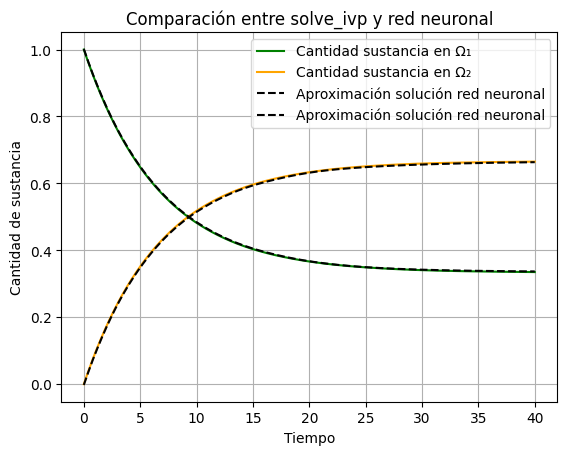

In [114]:
# Representación
plt.figure()
plt.plot(sol.t, sol.y[0].T, color='green', label="Cantidad sustancia en Ω₁")
plt.plot(sol.t, sol.y[1].T, color='orange', label="Cantidad sustancia en Ω₂")
plt.plot(tt,y,linestyle='--', color="black", label = "Aproximación solución red neuronal")

plt.legend()
plt.title("Comparación entre solve_ivp y red neuronal")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de sustancia")
plt.grid(True)
plt.show()

###- ERROR de ENTRENAMIENTO y EVOLUCIÓN del LEARNING RATE

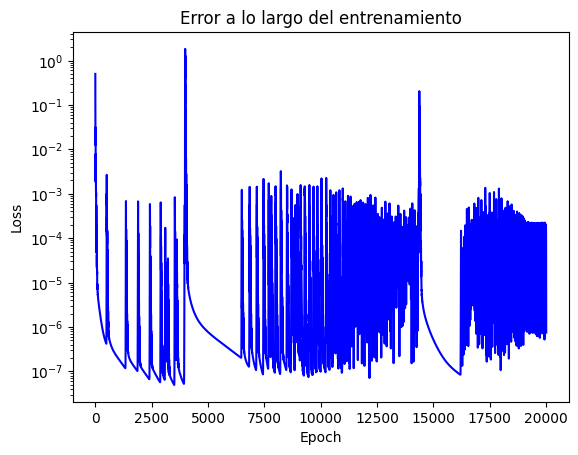

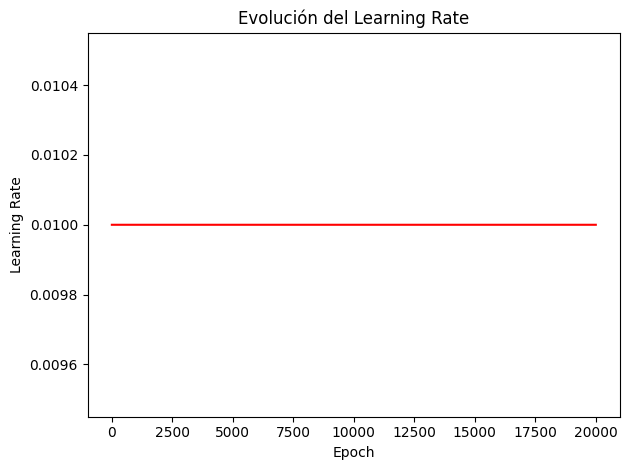

In [116]:
# Crear una figura con dos subgráficas
plt.figure(1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')            # escala logarítmica se utiliza generalmente cuando los valores de la pérdida varían en un rango amplio

plt.figure(2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()
